In [1]:
# Gerekli kütüphaneleri ekleme:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Veri setini indirip ekleme:
data = pd.read_excel("https://www.dropbox.com/s/luoopt5biecb04g/SATILIK_EV1.xlsx?dl=1")

In [3]:
# Veri setinin ilk 5 elemanını ekranda görüntüleme:
data.head()

,Unnamed: 0,Fiyat,Oda_Sayısı,Net_m2,Katı,Yaşı
0,0,475,1,40,0,6
1,1,475,1,55,0,5
2,2,450,1,50,0,7
3,3,450,1,55,1,6
4,4,475,1,45,2,7


In [4]:
# Hedef ve öznitelik değişkenlerini tanımlama:
X = data[["Oda_Sayısı", "Net_m2", "Katı", "Yaşı"]]
y = data["Fiyat"]

**Yorum**: Stochastic Gradient Descent özniteliklerin ve hedef değişkenin ölçeğine duyarlı olduğundan dolayı tüm değişkenler için ölçeklendirme uygulamak gerekmektedir. Bunun için StandardScaler() veya MinMaxScaler() kullanılabilir.

In [5]:
# Minimum-Maksimum yöntemiyle veri setini standartlaştırma:
from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X = X_scaler.fit_transform(X)
y = y_scaler.fit_transform(y.values.reshape(-1, 1))

In [6]:
# Veri setini rassal olarak eğitim ve test veri seti şeklinde ikiye bölümleme:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Stokastik Meyilli İniş doğrusal regresyonunun seçimi ve ızgara araması için parametrelerin tanımlanması:
from sklearn.linear_model import SGDRegressor
sgd_regressor = SGDRegressor(random_state=42, penalty="elasticnet")
parameters = {"alpha": [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 2, 3, 4, 5, 10, 20, 30, 50],
             "l1_ratio": [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
             "eta0": [1e-4, 1e-3, 1e-2, 1e-1],
             "learning_rate": ["constant", "optimal", "invscaling", "adaptive"],
             "max_iter": [50, 100, 500, 1000, 50000]}

from sklearn.model_selection import GridSearchCV
sgd_regressor_GS = GridSearchCV(estimator=sgd_regressor, param_grid=parameters, n_jobs=-1, scoring="r2", cv=5)

# Stokastik Meyilli İniş doğrusal regresyonu modelinin eğitimi:
sgd_regressor_GS.fit(X_train, y_train.ravel())

# Stokastik Meyilli İniş doğrusal regresyonu için optimum R2 ölçütünün değerini ekranda görüntüleme:
print("Optimum R2 value for the best SGD regression model over train set:", sgd_regressor_GS.best_score_)
print('\n')

# Stokastik Meyilli İniş doğrusal regresyonu için tanımlanan hiperparametre değerleri arasından seçilen optimum parametre değerlerini ekranda görüntüleme:
print("Optimum parameter values for SGD regression model:", sgd_regressor_GS.best_params_)
print('\n')

# Stokastik Meyilli İniş doğrusal regresyonu için optimum modelin parametre değerlerini ekranda görüntüleme:
print("Optimum model configuration for SGD regression model:", sgd_regressor_GS.best_estimator_)

Optimum R2 value for the best SGD regression model over train set: 0.7083899182622208


Optimum parameter values for SGD regression model: {'alpha': 0.001, 'eta0': 0.1, 'l1_ratio': 0.7, 'learning_rate': 'adaptive', 'max_iter': 50}


Optimum model configuration for SGD regression model: SGDRegressor(alpha=0.001, eta0=0.1, l1_ratio=0.7, learning_rate='adaptive',
             max_iter=50, penalty='elasticnet', random_state=42)


**Yorum**: En uygun ilk öğrenme oranı (adım boyu) 0.1 olarak, l1_ratio değeri ise 0.7 olarak bulunmuştur. l1_ratio değeri 0 (RIDGE regresyonu) ve 1 (LASSO regresyonu) değerlerinden farklı olduğu için klasik çoklu doğrusal regresyon modeli ElasticNet modeline göre değerlendirilecektir. Görüldüğü gibi elde edilen alpha değeri 0.001 gibi küçük bir değer olduğu için SGD optimizasyon algoritmasının ElasticNet ile ürettiği model klasik çoklu doğrusal regresyon modeline göre çok yakın ancak daha iyi sonuçlar üretecektir. 

In [8]:
# Izgara araması sonucu seçilen en iyi tahmincinin, yani en yüksek puanı veren tahminci için çapraz doğrulama yapma:
from sklearn.model_selection import cross_val_score
all_accuracies = cross_val_score(estimator=sgd_regressor_GS.best_estimator_, X=X_train, y=y_train.ravel(), cv=5)

# Çapraz doğrulamanın her bir çalışması için tahmin edicinin puanlarını/skorlarını ekranda görüntüleme:
print(all_accuracies)

# Çapraz doğrulamanın her bir çalışması sonucu elde edilen tahmin edicinin puanlarının ortalamasını ve standart sapmasını ekranda görüntüleme:
print(all_accuracies.mean())
print(all_accuracies.std())

[0.60528962 0.86596214 0.76049417 0.58436574 0.72583792]
0.7083899182622208
0.10378820699251781


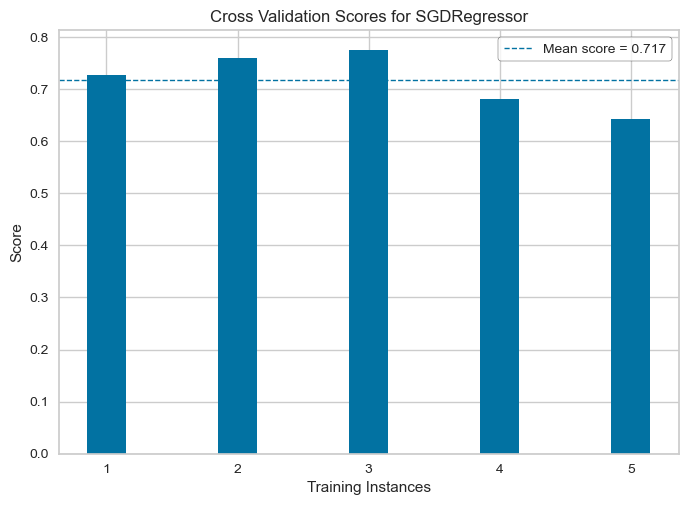

<Axes: title={'center': 'Cross Validation Scores for SGDRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [9]:
# Çapraz doğrulama sonuçlarının K-katlamalı Çapraz doğrulama aracılığyla görselleştirilmesi:
from yellowbrick.model_selection import CVScores
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)
model = sgd_regressor_GS.best_estimator_
visualizer = CVScores(model, cv=cv, scoring="r2")

visualizer.fit(X_train, y_train.ravel()) # Fit the data to the visualizer.
visualizer.show()    # Finalize and render the figure.

In [10]:
# Elde edilen en iyi modelin kesim parametresini elde etme:
sgd_regressor_GS.best_estimator_.intercept_

array([0.01692942])

In [11]:
# Elde edilen en iyi modelin eğim parametrelerini elde etme:
coefficient_df = pd.DataFrame(sgd_regressor_GS.best_estimator_.coef_, index=["Oda_Sayısı", "Net_m2", "Katı", "Yaşı"], columns=["SGD Regression Feature Coefficients"])
coefficient_df

,SGD Regression Feature Coefficients
Oda_Sayısı,0.293686
Net_m2,0.160577
Katı,0.111525
Yaşı,-0.127674


In [12]:
# En iyi Stokastik Meyilli İniş doğrusal regresyon modelinin R2 ölçütünü hesaplama (eğitim veri setinin üzerinden tahmin):
print("R2 for SGD regression model over train set:", sgd_regressor_GS.best_estimator_.score(X_train, y_train.ravel()))

# En iyi Stokastik Meyilli İniş doğrusal regresyon modelinin R2 ölçütünü hesaplama (test veri setinin üzerinden tahmin):
print("R2 for SGD regression model over test set:", sgd_regressor_GS.best_estimator_.score(X_test, y_test.ravel()))

R2 for SGD regression model over train set: 0.7321784405612313
R2 for SGD regression model over test set: 0.6901787126678489


In [13]:
from sklearn.metrics import mean_squared_error

# En iyi Stokastik Meyilli İniş doğrusal regresyon modelinin MSE ölçütünü hesaplama (eğitim veri setinin üzerinden tahmin):
MSE_train = mean_squared_error(y_train.ravel(), sgd_regressor_GS.best_estimator_.predict(X_train))
MSE_train = y_scaler.inverse_transform(MSE_train.reshape(-1, 1))
print("MSE for SGD regression model over train set:", MSE_train[0][0])

# En iyi Stokastik Meyilli İniş doğrusal regresyon modelinin MSE ölçütünü hesaplama (test veri setinin üzerinden tahmin):
MSE_test = mean_squared_error(y_test.ravel(), sgd_regressor_GS.best_estimator_.predict(X_test))
MSE_test = y_scaler.inverse_transform(MSE_test.reshape(-1, 1))
print("MSE for SGD regression model over test set:", MSE_test[0][0])

MSE for SGD regression model over train set: 454.3634585018962
MSE for SGD regression model over test set: 455.8369378079987


**Yorum**: SGD optimizasyonu sonucu belirlenen optimum modelin hatası eğitim verisi için 454, test veri seti için 455 olarak bulundu. Yani (sqrt(454)=21.307) eğitim seti için yapılan ev fiyatı tahmininin 21000 TL'lik bir ortalama hataya sahip olduğunu görüyoruz. Yanlılık sorunu eğitim seti üzerinden eğitilen modelin ürettiği tahmin modelinin eğitim setindeki hedef değişkeni yeterince iyi (düşük hata) ile tahmin edememesi durumunda ortaya çıkar. Buna göre, modelin bir miktar yanlılık sorunu bulunmaktadır.

Varyans sorunu ise modelin eğitim setinde yüksek performans gösterip test setinde düşük performans göstermesi durumunda ortaya çıkar. Modelin test setinin tahmin hatası (sqrt(455)=21.330) yaklaşık 21000 TL'dir. Bu durumda modelin varyans sorununun oldukça düşük olduğunu söyleyebiliriz.

In [14]:
# Veri setindeki tüm değerler için eğitilen en optimum modeli kullanarak fiyat tahmini yapma:
data["Predicted_Price"] = sgd_regressor_GS.best_estimator_.predict(X)
data["Predicted_Price"] = y_scaler.inverse_transform(data["Predicted_Price"].values.reshape(-1, 1)) # MinMaxScaler ile ölçekleme yapılmış değerler olması gerektiği değere ölçeklendirilmiştir.
print(data[["Fiyat", "Predicted_Price"]].head(5))

   Fiyat  Predicted_Price
0    475       439.132969
1    475       463.534165
2    450       448.972417
3    450       467.027856
4    475       456.825290


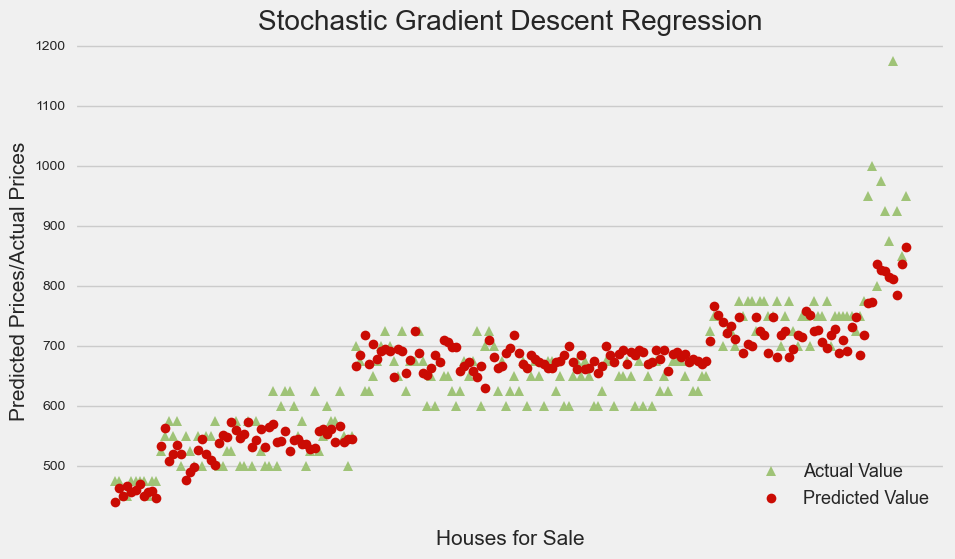

In [15]:
# Tüm veri setindeki evlerin gerçek değerleri ve model ile tahmin edilmiş fiyatlarının karşılaştırılması:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(10, 6))
plt.xticks(data["Fiyat"], data.index.values)
plt.plot(data["Fiyat"], "g^", label="Actual Value")
plt.xticks(data["Predicted_Price"], data.index.values)
plt.plot(data["Predicted_Price"], "ro", label="Predicted Value")
plt.title("Stochastic Gradient Descent Regression")
plt.xlabel("Houses for Sale", fontsize=15)
plt.ylabel("Predicted Prices/Actual Prices", fontsize=15)
plt.legend(fontsize=13, loc="lower right")
plt.show()